In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import gymnasium as gym

from gymnasium.wrappers.time_limit import TimeLimit

from dice_rl_TU_Vienna.environment import test_env
from dice_rl_TU_Vienna.wrappers import LoopingWrapper
from dice_rl_TU_Vienna.dataset import get_dataset
from dice_rl_TU_Vienna.value import get_get_policy_value, get_success_rate
from dice_rl_TU_Vienna.plot.tabular import plot_pvs, plot_sdc_errors
from dice_rl_TU_Vienna.plugins.stable_baselines3.policy import get_model_PPO
from dice_rl_TU_Vienna.plugins.stable_baselines3.dataset import get_probs

from dice_rl_TU_Vienna.estimators.get import (
    get_pv_s_OnPE, get_pv_s_OffPE, get_sdc_s, get_vaf_s, )
from dice_rl_TU_Vienna.estimators.tabular.test import (
    test_estimator, test_auxiliary_estimates, )
from dice_rl_TU_Vienna.estimators.tabular.tabular_vafe          import TabularVafe
from dice_rl_TU_Vienna.estimators.tabular.tabular_dice          import TabularDice
from dice_rl_TU_Vienna.estimators.tabular.tabular_dual_dice     import TabularDualDice
from dice_rl_TU_Vienna.estimators.tabular.tabular_gradient_dice import TabularGradientDice

from dice_rl_TU_Vienna.utils.general import iterate_print
from dice_rl_TU_Vienna.utils.bedtime import computer_sleep

from plugins.gymnasium.frozen_lake.config import *
from plugins.gymnasium.frozen_lake.analytical_solver import AnalyticalSolverFrozenLake
from plugins.gymnasium.frozen_lake.transition_lister import (
    get_transitions_sample, get_transitions_exact,
    list_transitions_sample, list_transitions_exact, )

/Users/richardweiss/Documents/.venvs/dice_rl_TU_Vienna/lib/python3.11/site-packages/tf_agents/__init__.py:58: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/Users/richardweiss/Documents/.venvs/dice_rl_TU_Vienna/lib/python3.11/site-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/Users/richardweiss/Documents/.venvs/dice_rl_TU_Vienna/lib/python3.11/site-packages/tf_agents/utils/common.py:91: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  distutils.version.LooseVersion(tf.__version__)


# Prepare

In [3]:
env = {
    kind: gym.make(
        "FrozenLake-v1", desc=None, map_name="4x4", is_slippery=is_slippery[kind],
    )
        for kind in kinds
}

env_looping = { k: LoopingWrapper(v) for k, v in env.items() }

env_looping_time_limit = {
    k: TimeLimit(env=v, max_episode_steps=max_episode_steps)
        for k, v in env_looping.items()
}

In [9]:
policy     = {}
id_policy  = {}
dir_policy = {}

for kind in kinds:
    x, y = get_model_PPO(
        dir_env[kind],
        env[kind],
        {
            "seed": seed,
            "total_timesteps": total_timesteps,
        },
        verbosity=1,
    )

    policy[kind] = x
    id_policy[kind] = y
    dir_policy[kind] = os.path.join(dir_env[kind], id_policy[kind])

get_act_deterministic_uniform = lambda obs: env["deterministic"].action_space.sample()
get_act_stochastic_uniform    = lambda obs: env["stochastic"]   .action_space.sample()

get_act_deterministic_policy = lambda obs: int( policy["deterministic"].predict(obs)[0] )
get_act_stochastic_policy    = lambda obs: int( policy["stochastic"]   .predict(obs)[0] )

get_act = {
    "deterministic": {
        "uniform": get_act_deterministic_uniform,
        "policy":  get_act_deterministic_policy,
    },
    "stochastic": {
        "uniform": get_act_stochastic_uniform,
        "policy":  get_act_stochastic_policy,
    },
}

trying to find id_policy in data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/policy.json
trying to load policy from data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/2025-02-10T12:49:12.104856/policy.zip
trying to find id_policy in data/gymnasium/frozenlake/2025-02-07T14:40:35.834973/policy.json
trying to load policy from data/gymnasium/frozenlake/2025-02-07T14:40:35.834973/2025-02-10T12:50:48.513450/policy.zip


In [37]:
dataset     = { kind: { by: {} for by in bys } for kind in kinds }
id_dataset  = { kind: { by: {} for by in bys } for kind in kinds }
dir_dataset = { kind: { by: {} for by in bys } for kind in kinds }

for kind in kinds:
    up = "uniform"

    x, y = get_dataset(
        dir_env[kind],
        env_looping[kind],
        get_act[kind][up],
        {
            "seed": seed,
            "n_samples": n_samples,
            "policy": None,
        },
        verbosity=1,
    )
    x["probs_init"] = list( get_probs(x["obs_init"], policy[kind], n_act) )
    x["probs_next"] = list( get_probs(x["obs_next"], policy[kind], n_act) )

    by = "by_samples"
    dataset    [kind][by][up] = x
    id_dataset [kind][by][up] = y
    dir_dataset[kind][by][up] = os.path.join(dir_env[kind], y)

for kind in kinds:
    up = "uniform"

    x, y = get_dataset(
        dir_env[kind],
        env_looping_time_limit[kind],
        get_act[kind][up],
        {
            "seed": seed,
            "n_trajectories": n_trajectories,
            "max_episode_steps": max_episode_steps,
            "policy": None,
        },
        verbosity=1,
    )

    by = "by_episodes"
    dataset    [kind][by][up] = x
    id_dataset [kind][by][up] = y
    dir_dataset[kind][by][up] = os.path.join(dir_policy[kind], y)

for kind in kinds:
    up = "policy"

    x, y = get_dataset(
        dir_policy[kind],
        env_looping_time_limit[kind],
        get_act[kind]["policy"],
        {
            "seed": seed,
            "n_trajectories": n_trajectories,
            "max_episode_steps": max_episode_steps,
            "policy": {
                "id": id_policy[kind],
            },
        },
        verbosity=1,
    )

    by = "by_episodes"
    dataset    [kind][by][up] = x
    id_dataset [kind][by][up] = y
    dir_dataset[kind][by][up] = os.path.join(dir_policy[kind], y)

trying to find id_dataset in data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/dataset.json
trying to load dataset from data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/2025-02-10T13:29:23.830090/dataset.parquet
trying to find id_dataset in data/gymnasium/frozenlake/2025-02-07T14:40:35.834973/dataset.json
trying to load dataset from data/gymnasium/frozenlake/2025-02-07T14:40:35.834973/2025-02-10T13:29:25.957165/dataset.parquet
trying to find id_dataset in data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/dataset.json
trying to load dataset from data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/2025-02-10T13:29:27.270453/dataset.parquet
trying to find id_dataset in data/gymnasium/frozenlake/2025-02-07T14:40:35.834973/dataset.json
trying to load dataset from data/gymnasium/frozenlake/2025-02-07T14:40:35.834973/2025-02-10T13:29:28.433936/dataset.parquet
trying to find id_dataset in data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/2025-02-10T12:49:12.104856/dataset.json
tr

In [28]:
success_rate = {
    kind: {
        up: get_success_rate(dataset[kind]["by_episodes"][up])
            for up in ["uniform", "policy"]
    }
        for kind in kinds
}

In [62]:
estimators_OnPE = {}

for kind in kinds:
    estimators_OnPE[kind] = get_get_policy_value(dataset[kind]["by_episodes"]["policy"])
    estimators_OnPE[kind].__name__ = "OnPE evaluation"

In [40]:
estimators_OffPE = {}
estimators_VAFE  = {}
estimators_DICE  = {}

for kind in iterate_print(kinds, "kind"):
    E = [
        estimator_type(
            dataset[kind]["by_samples"]["uniform"],
            n_obs, n_act,
            dir_dataset[kind]["by_samples"]["uniform"],
            verbosity=1,
        )
            for estimator_type in [
                TabularVafe, TabularDice, TabularDualDice, TabularGradientDice, ]
    ]

    estimators_OffPE[kind] = E
    estimators_VAFE [kind] = E[:1]
    estimators_DICE [kind] = E[1:]

kind=deterministic
trying to load auxiliary estimates from data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/2025-02-10T13:29:23.830090
loaded data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/2025-02-10T13:29:23.830090/d0_bar.npy
loaded data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/2025-02-10T13:29:23.830090/dD_bar.npy
loaded data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/2025-02-10T13:29:23.830090/P_bar.npy
loaded data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/2025-02-10T13:29:23.830090/r_bar.npy
loaded data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/2025-02-10T13:29:23.830090/n.npy
trying to load auxiliary estimates from data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/2025-02-10T13:29:23.830090
loaded data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/2025-02-10T13:29:23.830090/d0_bar.npy
loaded data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/2025-02-10T13:29:23.830090/dD_bar.npy
loaded data/gymnasium/frozenlake/2025-02-07T14:39:02.410219/20

In [41]:
transitions = { "sample": {}, "exact": {}, }

for kind in kinds:
    x = get_transitions_sample(env_looping[kind], n_transitions=1_000)
    y = get_transitions_exact(x)

    transitions["sample"][kind] = x
    transitions["exact"] [kind] = y


analytical_solver = {
    kind: AnalyticalSolverFrozenLake(
        policy=policy[kind],
        transitions=transitions["exact"][kind],
    )
        for kind in kinds
}

100%|██████████| 64/64 [00:00<00:00, 9334.94it/s]


# `get_pvs` & `get_sdcs`

In [57]:
pvs_OnPE = {
    kind: get_pv_s_OnPE(
        estimator_s=estimators_OnPE[kind],
        gamma_s=gammas,
    )
        for kind in kinds
}

In [47]:
pvs_VAFE = {
    kind: get_pv_s_OffPE(
        estimator_s=estimators_VAFE[kind],
        gamma_s=gammas,
        projected=projected, weighted=None,
        modified=modified, lamda=lamda,
    )
        for kind in kinds
}

pvs_DICE_s = {
    kind: get_pv_s_OffPE(
        estimator_s=estimators_DICE[kind],
        gamma_s=gammas,
        projected=projected, weighted=False,
        modified=modified, lamda=lamda,
    )
        for kind in kinds
}

pvs_DICE_w = {
    kind: get_pv_s_OffPE(
        estimator_s=estimators_DICE[kind],
        gamma_s=gammas,
        projected=projected, weighted=True,
        modified=modified, lamda=lamda,
    )
        for kind in kinds
}

pvs_DICE = { False: pvs_DICE_s, True: pvs_DICE_w, }

In [48]:
sdcs_DICE = {
    kind: get_sdc_s(
        estimator_s=estimators_DICE[kind],
        gamma_s=gammas,
        projected=projected,
        modified=modified, lamda=lamda,
    )
        for kind in kinds
}

vafs = {
    kind: get_vaf_s(
        estimator_s=estimators_VAFE[kind],
        gamma_s=gammas,
        projected=projected,
    )
        for kind in kinds
}

In [49]:
pvs_exact = {}; vafs_exact = {}; sdcs_exact = {}

for kind in kinds:
    pv_list = []
    vaf_list = []
    sdc_list = []

    for gamma in gammas:
        pv, (vaf, sdc), _ = analytical_solver[kind].solve(gamma) # type: ignore

        pv_list .append(pv)
        sdc_list.append(sdc)

    pvs_exact [kind] = np.array(pv_list)
    vafs_exact[kind] = np.array(vaf_list)
    sdcs_exact[kind] = np.array(sdc_list)

In [56]:
pv_OnPE = {
    kind: get_pv_s_OnPE(
        estimator_s=estimators_OnPE[kind],
        gamma_s=1.0,
    )
        for kind in kinds
}

In [52]:
pv_DICE_s = {}
pv_DICE_w = {}
sdc_DICE = {}
ev_DICE = {}

for kind in kinds:
    pv_hat, *_ = estimators_DICE[kind][0].solve(
        gamma=1, projected=projected, weighted=False, modified=modified)

    pv_DICE_s[kind] = pv_hat

    pv_hat, *_ = estimators_DICE[kind][0].solve(
        gamma=1, projected=projected, weighted=True, modified=modified)

    pv_DICE_w[kind] = pv_hat

    sdc_hat, info = estimators_DICE[kind][0].solve_sdc(
        gamma=1, projected=projected, modified=modified)

    sdc_DICE[kind] = sdc_hat
    ev_DICE[kind] = info["ev_approx"]

In [53]:
pv_exact = {}
sdc_exact = {}
ev_exact = {}

for kind in kinds:
    pv, sdc, info = analytical_solver[kind].solve(
        gamma=1, primal_dual="dual") # type: ignore

    pv_exact[kind] = pv
    sdc_exact[kind] = sdc
    ev_exact[kind] = info["ev"]

pv_DICE = { False: pv_DICE_w, True: pv_DICE_w, }

In [55]:
ev_DICE, ev_exact

({'deterministic': (1.0000000279911192+0j),
  'stochastic': (1.0000000073853599+0j)},
 {'deterministic': (1.0000000774503317+0j),
  'stochastic': (1.0000000798870277+0j)})

# Plot

## Policy Values

In [59]:
def plot_pvs_frozenlake(kind, weighted, errors):

    estimators = [ estimators_OnPE[kind], ] + estimators_OffPE[kind]
    if not errors: estimators.append( analytical_solver[kind] )
    pvs = [ pvs_OnPE[kind], ] + list(pvs_VAFE[kind]) + list(pvs_DICE[weighted][kind])
    if not errors: pvs.append( pvs_exact[kind] )
    pv_ref = pvs_exact[kind]
    pv_lims = [ pv_OnPE[kind], pv_DICE[weighted][kind], ]
    if not errors: pv_lims.append( pv_exact[kind] )
    pv_lim_ref = pv_exact[kind]
    labels = None
    c  = colors     if not errors else colors[:-1]
    cl = colors_lim if not errors else colors_lim[:-1]
    m  = markers     if not errors else markers[:-1]
    ml = markers_lim if not errors else markers_lim[:-1]
    measure = "PV Errors" if errors else "PVs"
    suptitle = f"{env_title} - {kind} - {measure}"
    one_minus_gamma = True
    xlabel = None
    ylabel = None
    scale_x = True
    scale_y = errors
    scale_pv = False
    ylim = None
    legend = True
    dir = dir_images

    plot_pvs(
        estimators,
        gammas,
        projected, weighted,
        modified, lamda,
        #
        pvs, pv_lims, pv_ref, pv_lim_ref,
        labels,
        c, cl,
        m, ml,
        suptitle,
        one_minus_gamma, errors,
        xlabel, ylabel,
        scale_x, scale_y,
        scale_pv,
        ylim, legend,
        dir,
    )

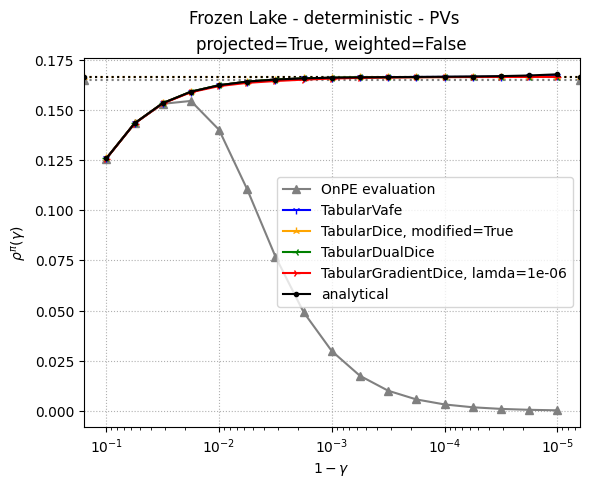

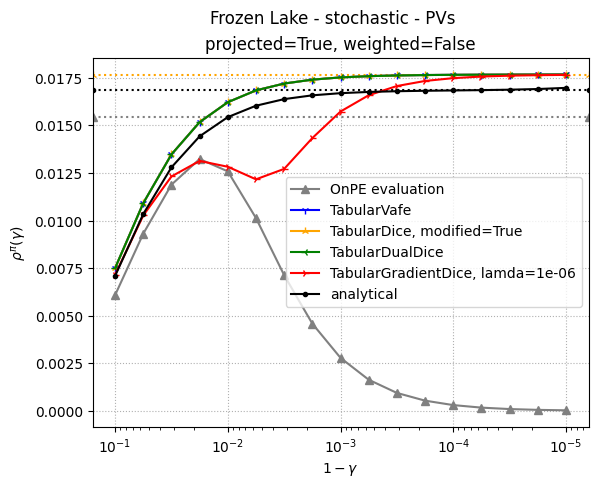

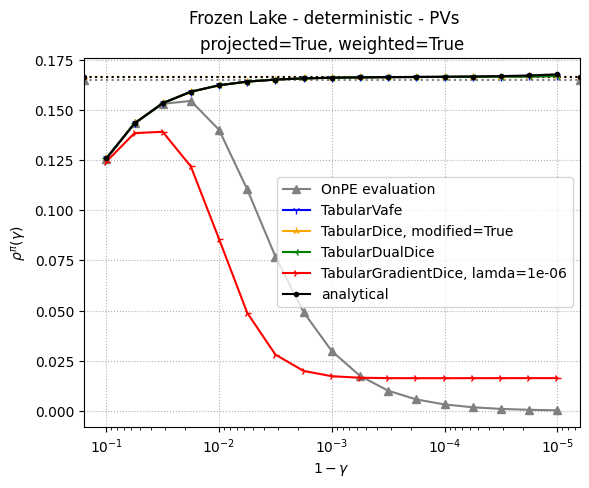

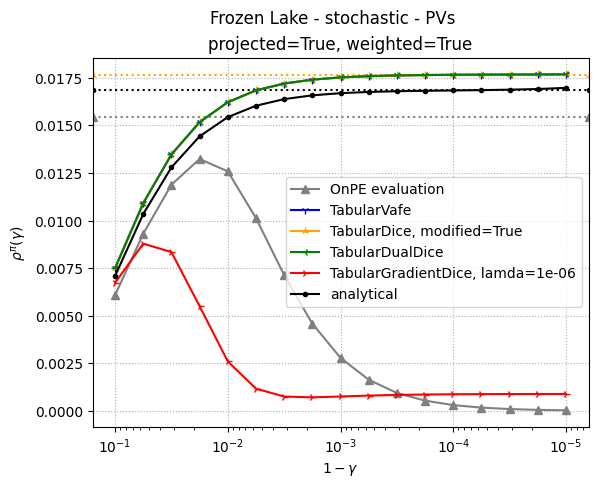

In [63]:
for weighted in [False, True]:
    for kind in kinds:
        plot_pvs_frozenlake(kind, weighted, errors=False)

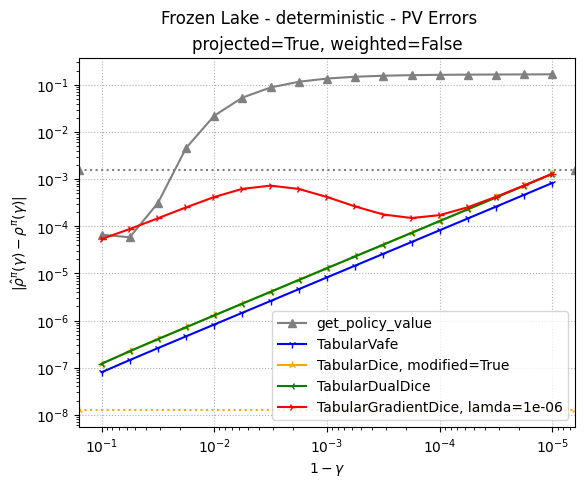

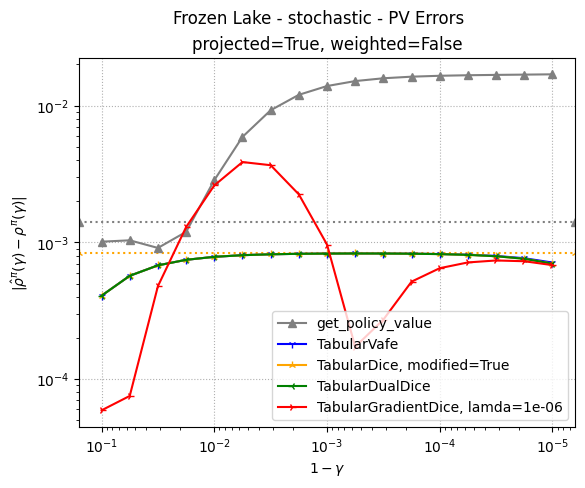

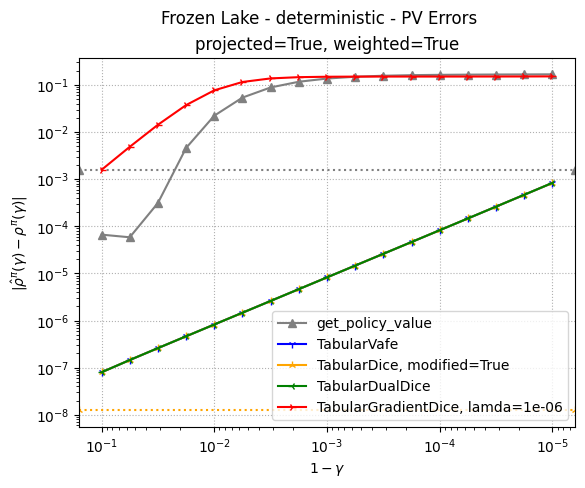

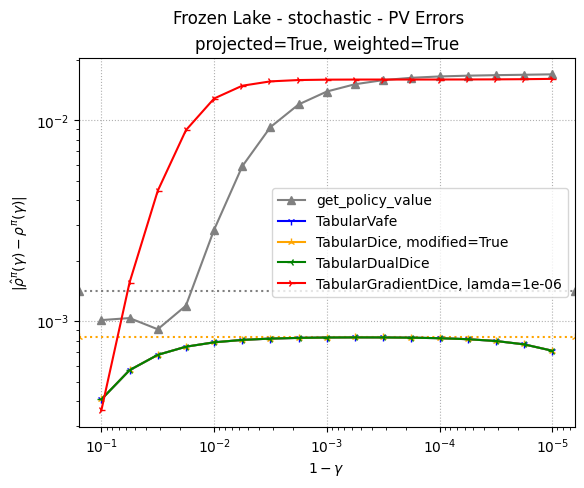

In [61]:
for weighted in [False, True]:
    for kind in kinds:
        plot_pvs_frozenlake(kind, weighted, errors=True)

## Stationary Distribution Corrections

In [64]:
def plot_sdc_errors_frozenlake(kind):

    estimators = estimators_DICE[kind]
    sdcs = sdcs_DICE[kind]
    sdc_lims = [ sdc_DICE[kind], ]
    sdc_ref = sdcs_exact[kind]
    sdc_lim_ref = sdc_exact[kind]
    c = colors_DICE
    cl = [ colors_DICE[0], ]
    m = markers_DICE
    ml = [ markers_DICE[0], ]
    measure = "SDC MSEs"
    suptitle = f"{env_title} - {kind} - {measure}"
    one_minus_gamma = True
    scale_x = True
    scale_y = True
    ylim = None
    legend = True
    dir = dir_images

    plot_sdc_errors(
        estimators,
        gammas,
        projected,
        modified, lamda,
        #
        sdcs, sdc_lims, sdc_ref, sdc_lim_ref,
        c, cl,
        m, ml,
        suptitle,
        one_minus_gamma,
        scale_x, scale_y, ylim, legend,
        dir,
    )

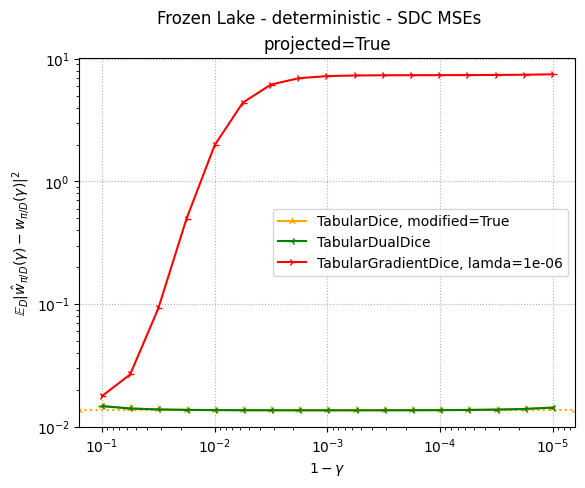

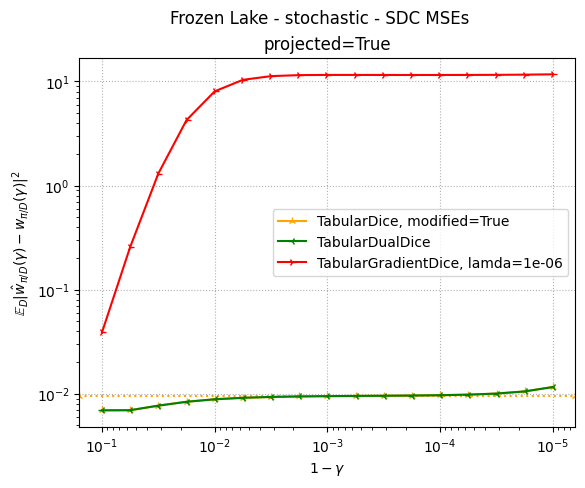

In [65]:
for kind in kinds:
    plot_sdc_errors_frozenlake(kind)

# Test

## `env` & `env_wrapped`

In [97]:
def execute_test_env(kind, up, num_trajectory, max_trajectory_length=None):
    print(kind); print()
    data = test_env(
        env=env[kind],
        get_act=get_act[kind][up],
        num_trajectory=num_trajectory,
        max_trajectory_length=max_trajectory_length,
        verbosity=2,
    )
    display(data)

In [98]:
execute_test_env(
    kind="deterministic",
    up="uniform",
    num_trajectory=2,
)

deterministic

0, 3 0.0
0, 0 0.0
0, 0 0.0
0, 1 0.0
4, 2 0.0
5, terminated

0, 3 0.0
0, 2 0.0
1, 0 0.0
0, 3 0.0
0, 0 0.0
0, 2 0.0
1, 3 0.0
1, 3 0.0
1, 1 0.0
5, terminated



{'distinct_absolute': (3.0, 0.0),
 'distinct_relative': (0.4, 0.1),
 'all': (8.0, 2.0)}

In [100]:
execute_test_env(
    kind="stochastic",
    up="uniform",
    num_trajectory=2,
)

stochastic

0, 3 0.0
0, 2 0.0
4, 1 0.0
5, terminated

0, 1 0.0
4, 1 0.0
4, 1 0.0
5, terminated



{'distinct_absolute': (3.0, 0.0),
 'distinct_relative': (0.75, 0.0),
 'all': (4.0, 0.0)}

In [ ]:
execute_test_env(
    kind="deterministic",
    up="policy",
    num_trajectory=2,
)

deterministic

0, 1 0.0
4, 1 0.0
8, 2 0.0
9, 2 0.0
10, 1 0.0
14, 2 1.0
15, terminated

0, 1 0.0
4, 1 0.0
8, 2 0.0
9, 1 0.0
13, 2 0.0
14, 2 1.0
15, terminated



{'distinct_absolute': (7.0, 0.0),
 'distinct_relative': (1.0, 0.0),
 'all': (7.0, 0.0)}

In [101]:
execute_test_env(
    kind="stochastic",
    up="policy",
    num_trajectory=2,
)

stochastic

0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
4, 0 0.0
4, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
4, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
4, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
4, 0 0.0
0, 0 0.0
4, 0 0.0
8, 3 0.0
9, 1 0.0
8, 3 0.0
4, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
4, 0 0.0
4, 0 0.0
8, 3 0.0
8, 3 0.0
4, 0 0.0
8, 3 0.0
4, 0 0.0
0, 0 0.0
4, 0 0.0
4, 0 0.0
4, 0 0.0
4, 0 0.0
4, 0 0.0
4, 0 0.0
8, 3 0.0
8, 3 0.0
9, 1 0.0
13, 2 0.0
9, 1 0.0
10, 0 0.0
9, 1 0.0
8, 3 0.0
9, 1 0.0
13, 2 0.0
14, 1 0.0
13, 2 0.0
13, 2 0.0
13, 2 0.0
9, 1 0.0
10, 0 0.0
9, 1 0.0
10, 0 0.0
6, 1 0.0
7, terminated

0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
0, 0 0.0
4, 0 0.0
8, 3 0.0
9, 1 0.0
10, 0 0.0
14, 1 0.0
14, 1 0.0
14, 1 0.0
13, 2 0.0
13, 2 0.0
14, 1 0.0
13, 2 0.0
14, 3 0.0
10, 0 0.0
9, 1 0.0
10, 0 0.0
6, 2 0.0
7, terminated



{'distinct_absolute': (9.0, 0.0),
 'distinct_relative': (0.2556818181818182, 0.11931818181818182),
 'all': (45.0, 21.0)}

## `transitions_lister`

In [80]:
def list_transitions(se, kind):
    print(kind); print()

    if se == "sample": f = list_transitions_sample
    if se == "exact":  f = list_transitions_exact

    df = f(transitions[se][kind])
    display(df)

In [82]:
for kind in kinds:
    print("#", "-"*64, "#", "\n")
    list_transitions("sample", kind)

# ---------------------------------------------------------------- # 

deterministic



,obs,act,obs_next,rew
0,0,0,"[(0, 1000)]","[(0.0, 1000)]"
1,0,1,"[(4, 1000)]","[(0.0, 1000)]"
2,0,2,"[(1, 1000)]","[(0.0, 1000)]"
3,0,3,"[(0, 1000)]","[(0.0, 1000)]"
4,1,0,"[(0, 1000)]","[(0.0, 1000)]"
...,...,...,...,...
59,14,3,"[(10, 1000)]","[(0.0, 1000)]"
60,15,0,"[(0, 1000)]","[(0, 1000)]"
61,15,1,"[(0, 1000)]","[(0, 1000)]"
62,15,2,"[(0, 1000)]","[(0, 1000)]"


# ---------------------------------------------------------------- # 

stochastic



,obs,act,obs_next,rew
0,0,0,"[(0, 686), (4, 314)]","[(0.0, 1000)]"
1,0,1,"[(0, 346), (1, 289), (4, 365)]","[(0.0, 1000)]"
2,0,2,"[(0, 317), (1, 345), (4, 338)]","[(0.0, 1000)]"
3,0,3,"[(0, 661), (1, 339)]","[(0.0, 1000)]"
4,1,0,"[(0, 666), (1, 334)]","[(0.0, 1000)]"
...,...,...,...,...
59,14,3,"[(0, 354), (10, 323), (13, 323)]","[(0.0, 646), (1.0, 354)]"
60,15,0,"[(0, 1000)]","[(0, 1000)]"
61,15,1,"[(0, 1000)]","[(0, 1000)]"
62,15,2,"[(0, 1000)]","[(0, 1000)]"


In [83]:
for kind in kinds:
    print("#", "-"*64, "#", "\n")
    list_transitions("exact", kind)

# ---------------------------------------------------------------- # 

deterministic



,obs,act,obs_next,probs,rew
0,0,0,0,1,0
1,0,1,4,1,0
2,0,2,1,1,0
3,0,3,0,1,0
4,1,0,0,1,0
...,...,...,...,...,...
59,14,3,10,1,0
60,15,0,0,1,0
61,15,1,0,1,0
62,15,2,0,1,0


# ---------------------------------------------------------------- # 

stochastic



,obs,act,obs_next,probs,rew
0,0,0,"[0, 4]","[2/3, 1/3]",0
1,0,1,"[0, 1, 4]","[1/3, 1/3, 1/3]",0
2,0,2,"[0, 1, 4]","[1/3, 1/3, 1/3]",0
3,0,3,"[0, 1]","[2/3, 1/3]",0
4,1,0,"[0, 1]","[2/3, 1/3]",0
...,...,...,...,...,...
59,14,3,"[0, 10, 13]","[1/3, 1/3, 1/3]",1/3
60,15,0,0,1,0
61,15,1,0,1,0
62,15,2,0,1,0


## Estimators

/Users/richardweiss/Library/CloudStorage/OneDrive-Persönlich/Masterarbeit/dice_rl_TU_Vienna/dice_rl_plugins/estimators/tabular/test.py:194: DeprecationWarning: invalid escape sequence '\q'
  


(s, a) visited:
{'absolute': 64, 'relative': 1.0}
(s, a) not visited:
{'absolute': 0, 'relative': 0.0}

# dD_bar[i] == 0, but P_bar[i, :] != 0: 0
# dD_bar[i] == 0, but P_bar[:, i] != 0: 0
# dD_bar[i], but d0_bar[i] != 0: 0

# ---------------------------------------------------------------- # 



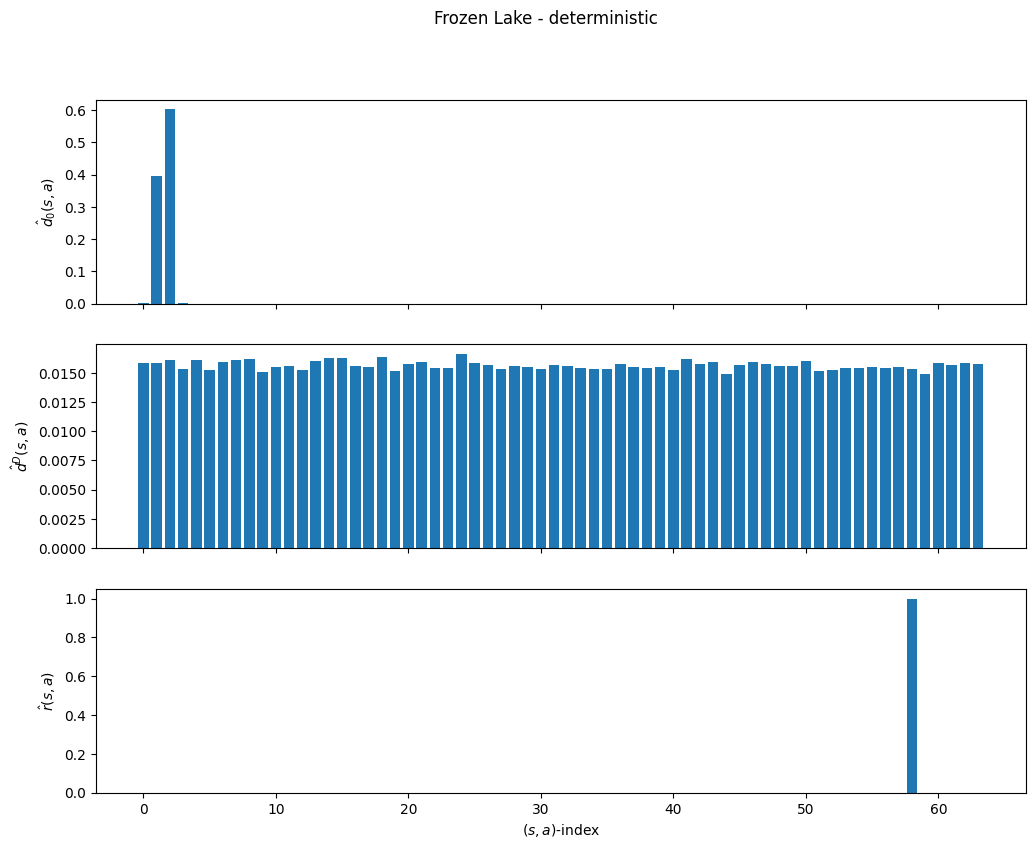

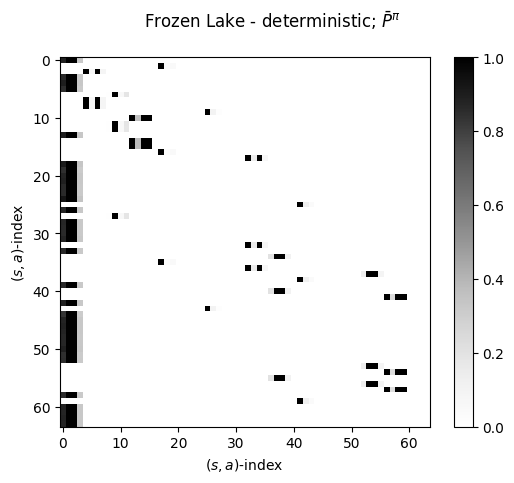

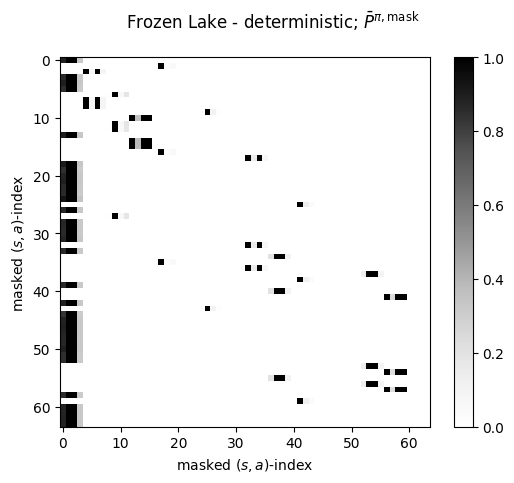

# ---------------------------------------------------------------- # 



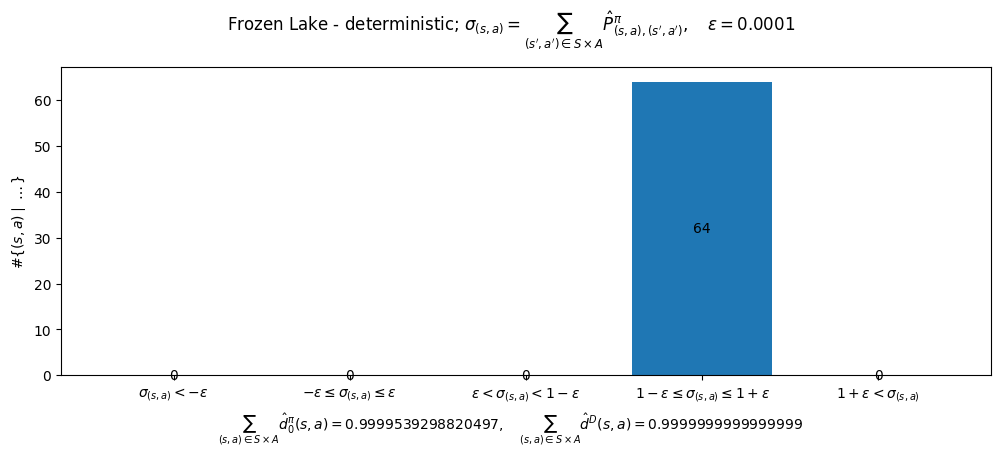

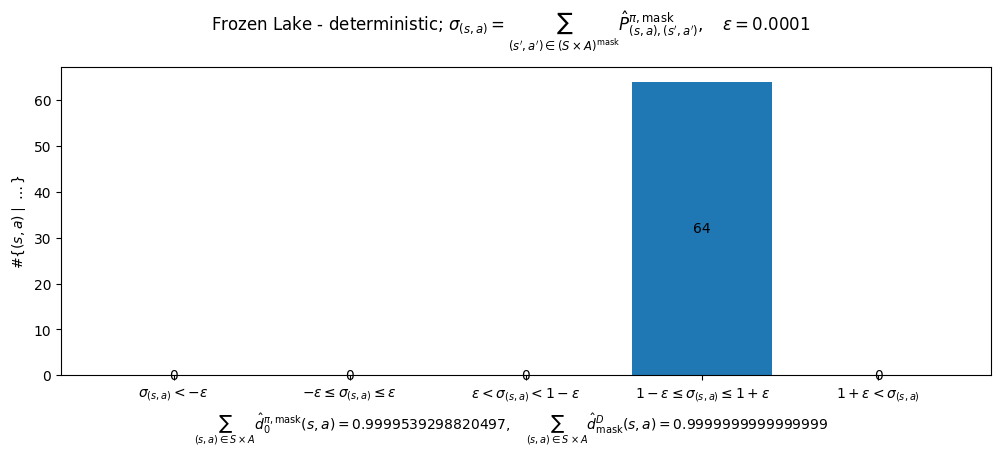

# ---------------------------------------------------------------- # 



In [589]:
k = "d"

test_auxiliary_estimates(
    auxiliary_estimates=auxiliary_estimates[k],
    title_prefix=f"Frozen Lake - {names[k]}",
    save_dir=os.path.join(save_dir_images, "auxiliary_estimates"),
)

(s, a) visited:
{'absolute': 64, 'relative': 1.0}
(s, a) not visited:
{'absolute': 0, 'relative': 0.0}

# dD_bar[i] == 0, but P_bar[i, :] != 0: 0
# dD_bar[i] == 0, but P_bar[:, i] != 0: 0
# dD_bar[i], but d0_bar[i] != 0: 0

# ---------------------------------------------------------------- # 



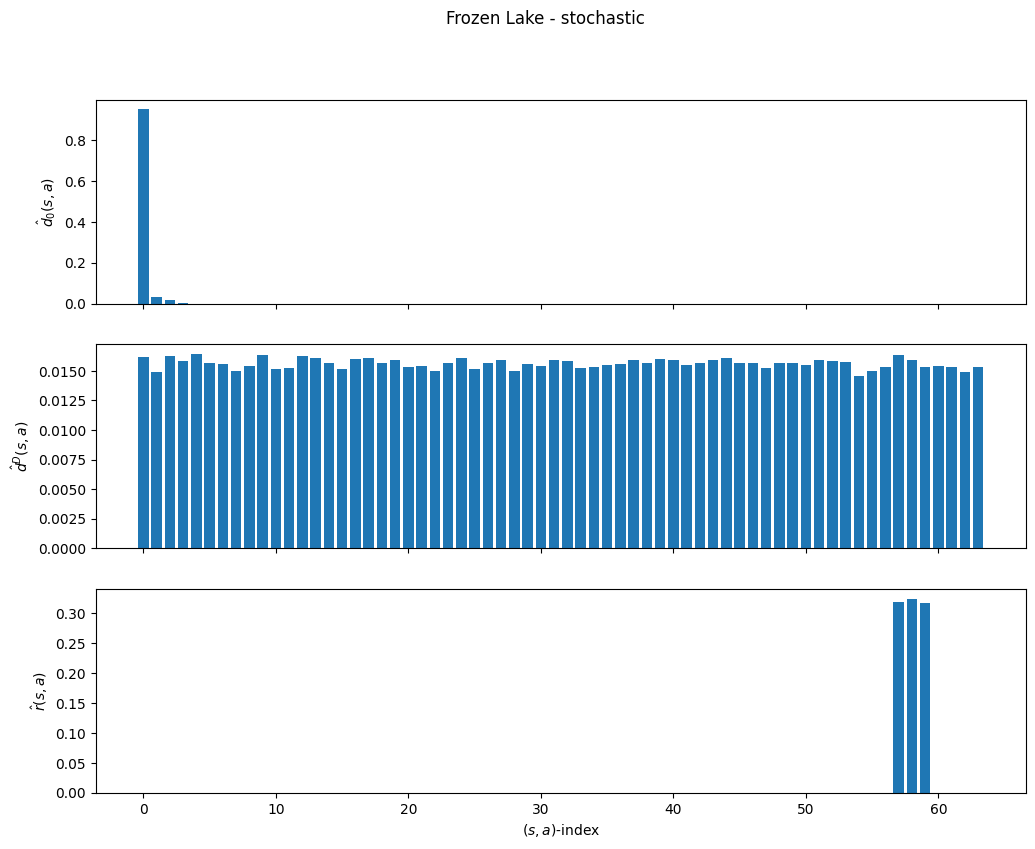

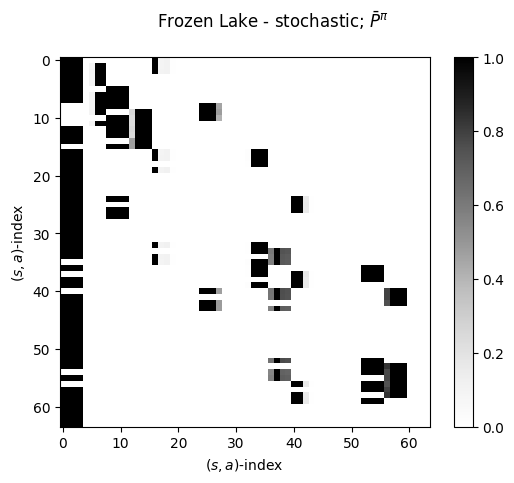

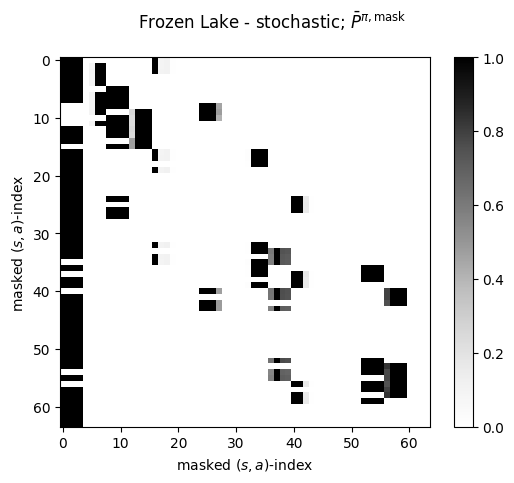

# ---------------------------------------------------------------- # 



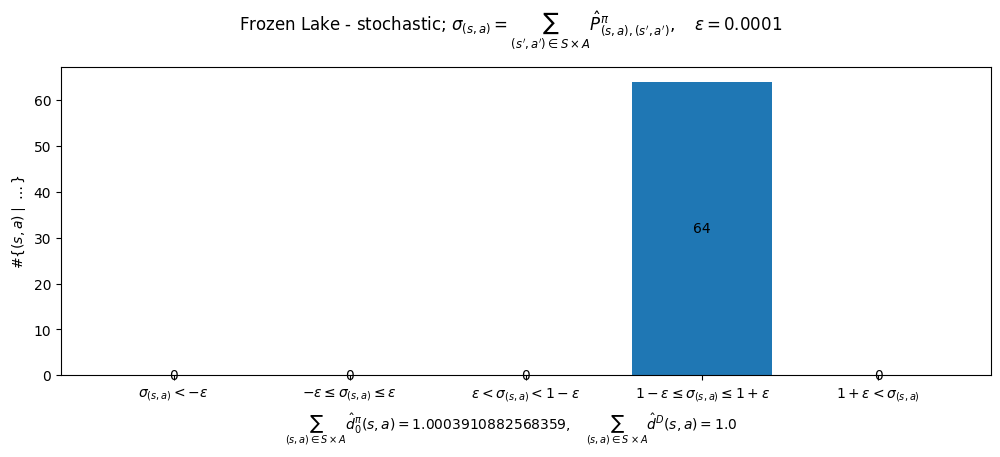

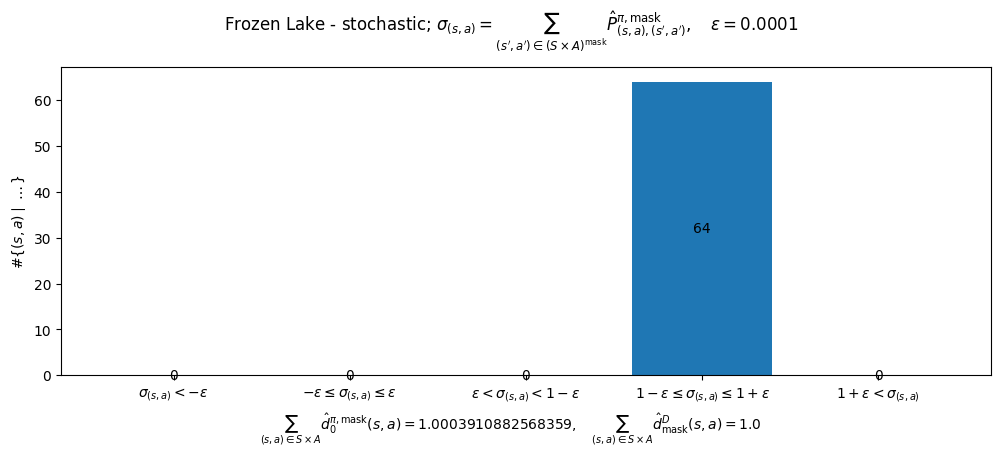

# ---------------------------------------------------------------- # 



In [590]:
k = "s"

test_auxiliary_estimates(
    auxiliary_estimates=auxiliary_estimates[k],
    title_prefix=f"Frozen Lake - {names[k]}",
    save_dir=os.path.join(save_dir_images, "auxiliary_estimates"),
)

pv=0.11820856481790543
np.dot(sdc_hat, dD_hat)=0.9999221925030817



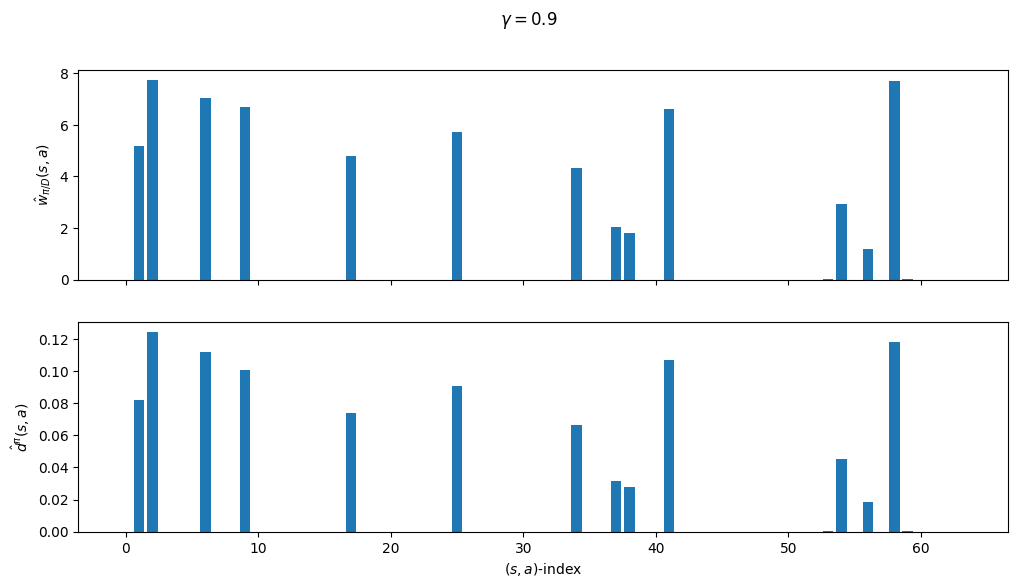

In [586]:
test_estimator(
    estimator_DICE=estimators_DICE["d"][0],
    gamma=0.9,
    projected=projected, weighted=True,
    modified=modified,
)

pv=0.00685409689322114
np.dot(sdc_hat, dD_hat)=1.0003738501990334



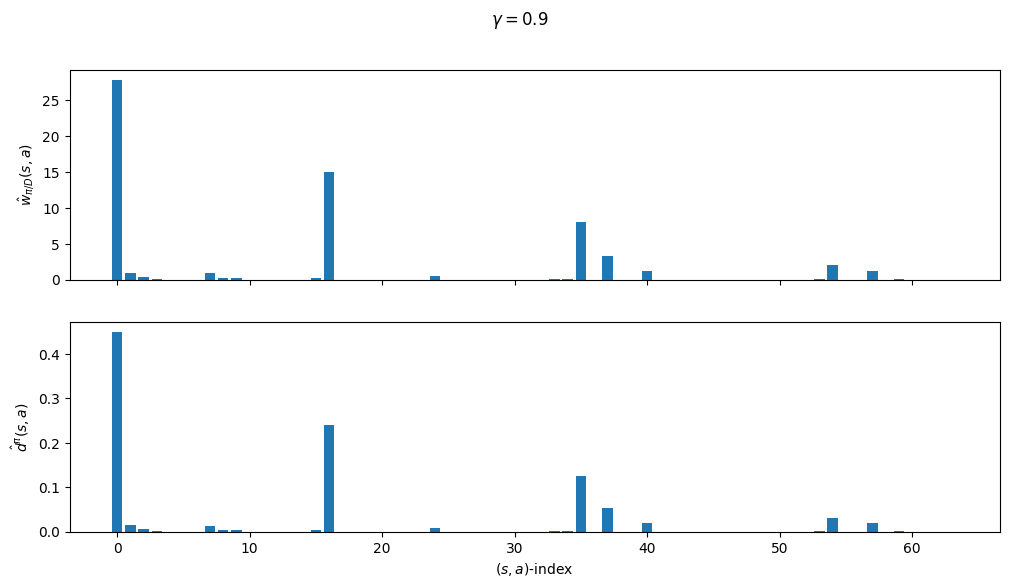

In [587]:
test_estimator(
    estimator_DICE=estimators_DICE["s"][0],
    gamma=0.9,
    projected=projected, weighted=True,
    modified=modified,
)

In [ ]:
for kind in kinds:
    print(names[k])
    d = get_error_auxiliary_estimates(
        auxiliary_estimates=auxiliary_estimates[k],
        analytical_solver=analytical_solver[k],
    )
    display(d)

deterministic


{'sum': {'d0': 1.220203200326392e-07,
  'dD': 7.751600000000006e-06,
  'P': 9.194384339681043e-09},
 'mean': {'d0': 1.9065675005099874e-09,
  'dD': 1.2111875000000009e-07,
  'P': 2.244722739179942e-12},
 'masked': {'d0': 3.05050800081598e-08,
  'dD': 1.2111875000000009e-07,
  'P': 3.5915563826879074e-11}}

stochastic


{'sum': {'d0': 1.6571244992279378e-07,
  'dD': 1.02318e-05,
  'P': 0.014274415297264136},
 'mean': {'d0': 2.589257030043653e-09,
  'dD': 1.59871875e-07,
  'P': 3.484964672183627e-06},
 'masked': {'d0': 4.1428112480698445e-08,
  'dD': 1.59871875e-07,
  'P': 2.5131012847296012e-05}}